***Importamos las librerías necesarias :***

In [1]:
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array

***Guardamos las imágenes con sus respectivas clases en "complete_df" :***

In [2]:
zip_path = './Imagenes/Trayectorias_comprimidas/raw-img.zip'

complete_df = pd.DataFrame()

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    file_list = [f for f in zip_ref.namelist() if f.startswith('raw-img/') and f.lower().endswith(('.png'))]
    complete_df['file_name'] = pd.Series(file_list)
    complete_df['class_name'] = complete_df['file_name'].map(lambda x: x.split('/')[-2])

#### COMPROBACIÓN ####
print("Número total de imágenes:", len(complete_df))
class_counts = complete_df['class_name'].value_counts()
print(class_counts)

Número total de imágenes: 14486
class_name
Fishing      2927
Cargo        2919
Tanker       2892
Container    2886
Cruise       2862
Name: count, dtype: int64


***Dividimos "complete_df" en entrenamiento y test :***

In [3]:
complete_df = complete_df.sample(frac=1, random_state=42).reset_index(drop=True)

test_size = 0.2
train_df_list = []
test_df_list = []

classes = complete_df['class_name'].unique()

for class_name in classes:
    class_subset = complete_df[complete_df['class_name'] == class_name]
    
    test_count = int(len(class_subset) * test_size)
    
    test_df_list.append(class_subset.iloc[:test_count])
    train_df_list.append(class_subset.iloc[test_count:])

train_df = pd.concat(train_df_list).reset_index(drop=True)
test_df = pd.concat(test_df_list).reset_index(drop=True)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

#### COMPROBACIÓN ####
print(f"Nº de imágenes en train: {len(train_df)}")
print(train_df['class_name'].value_counts())
print()
print(f"Nº de imágenes en test: {len(test_df)}")
print(test_df['class_name'].value_counts())
print()
print("Ejm. conjunto train:")
print(train_df.head(5))
print()
print("Ejm. conjunto test:")
print(test_df.head(5))

Nº de imágenes en train: 11591
class_name
Fishing      2342
Cargo        2336
Tanker       2314
Container    2309
Cruise       2290
Name: count, dtype: int64

Nº de imágenes en test: 2895
class_name
Fishing      585
Cargo        583
Tanker       578
Container    577
Cruise       572
Name: count, dtype: int64

Ejm. conjunto train:
                                           file_name class_name
0      raw-img/Cargo/Trayectoria_comprimida_1392.png      Cargo
1  raw-img/Container/Trayectoria_comprimida_8636.png  Container
2    raw-img/Fishing/Trayectoria_comprimida_7630.png    Fishing
3     raw-img/Tanker/Trayectoria_comprimida_4458.png     Tanker
4      raw-img/Cargo/Trayectoria_comprimida_9364.png      Cargo

Ejm. conjunto test:
                                           file_name class_name
0   raw-img/Fishing/Trayectoria_comprimida_11974.png    Fishing
1  raw-img/Container/Trayectoria_comprimida_15633...  Container
2     raw-img/Cruise/Trayectoria_comprimida_2902.png     Cruise
3     r

***Imágenes de entrenamiento y test antes del pre-procesado :***

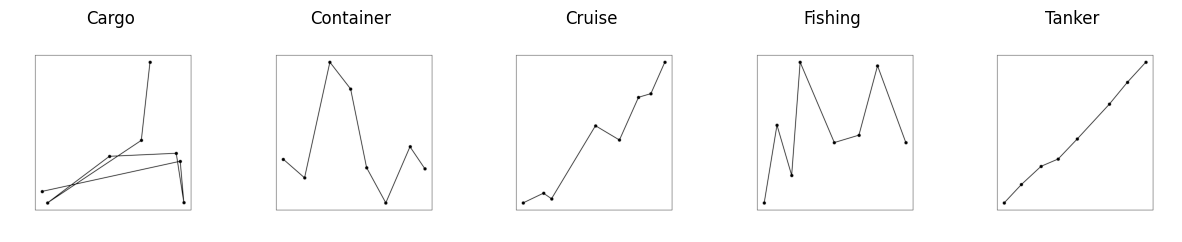

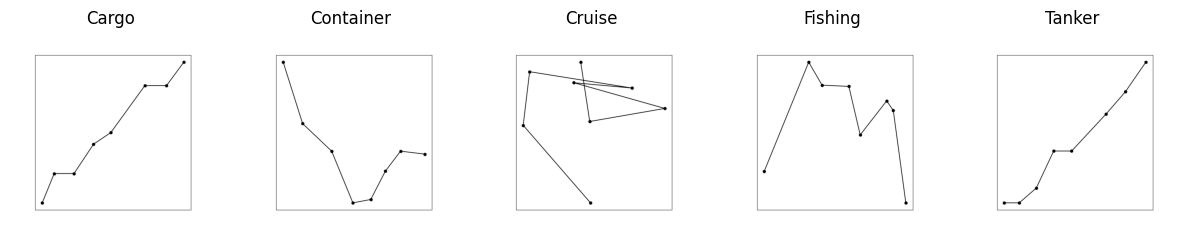

In [4]:
def mostrar_imagenes_antes_preprocesado(df):
    plt.figure(figsize=(15, 15))
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        grouped = df.groupby('class_name')
        for i, (class_name, group) in enumerate(grouped):
            image_path = group['file_name'].iloc[0]
            with zip_ref.open(image_path) as image_file:
                image = Image.open(image_file).convert("RGB")
            plt.subplot(1, len(grouped), i + 1)
            plt.imshow(image)
            plt.title(class_name)
            plt.axis('off')
    plt.show()

mostrar_imagenes_antes_preprocesado(train_df)
mostrar_imagenes_antes_preprocesado(test_df)


***Pre-procesado de las imágenes :***

In [5]:
IMG_SIZE = (227, 227)
X_train = []
y_train = []
X_test = []
y_test = []

def preprocesado_imagen(zip_ref, image_path):
    with zip_ref.open(image_path) as image_file:
        image = Image.open(image_file)
        image = image.convert("RGB")
        image = image.resize(IMG_SIZE)
        image = img_to_array(image) / 255.0
        return image

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for index, row in train_df.iterrows():
        image = preprocesado_imagen(zip_ref, row['file_name'])
        X_train.append(image)
        y_train.append(row['class_name'])

    for index, row in test_df.iterrows():
        image = preprocesado_imagen(zip_ref, row['file_name'])
        X_test.append(image)
        y_test.append(row['class_name'])

X_train = np.array(X_train, dtype="float32")
X_test = np.array(X_test, dtype="float32")

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)

#### COMPROBACIÓN ####
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (11591, 227, 227, 3)
X_test: (2895, 227, 227, 3)
y_train: (11591, 5)
y_test: (2895, 5)
